similar to cases_study_heat.ipynb 

 1 ) Feb 2021 event (February 13–17, 2021 North American winter storm):
 - 1.1) minumum temperature during the event
 - 1.2) Number of days with Tmin<0 for the event
 2) Winter Storm in Future scenario 

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import geoplot as gplt

In [2]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'
dir_o = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/'

####  geospatial plot
Because of high resolution shapefile, there is no PRISM grid inside a lot of shapes. I calculate the centroid of those polygons and then use the nearest prism grid data

In [3]:
flnm_shp = '/glade/work/mingge/SHAPEFILES/COUNTY_OREGON/sovi_3county_SD/sovi_3_county.shp'
shp_gpd = gpd.read_file(flnm_shp)

#crs={'init':'epsg:4326'}
#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

# Get lat-lon of geodataframe polygon, and then add them back
# I use centroid of the shape
#  reproject geodataframe to a geographic CRS, e.g EPSG:4326 
# nc_counties = shp_gpd.to_crs(4326)
#shp_gpd = shp_gpd.set_crs('EPSG:4326')
shp_gpd['lon_centroid'] = shp_gpd.centroid.x  
shp_gpd['lat_centroid'] = shp_gpd.centroid.y

n_shp = len(shp_gpd.centroid)

/glade/scratch/mingge/ipykernel_198699/554569368.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lon_centroid'] = shp_gpd.centroid.x
/glade/scratch/mingge/ipykernel_198699/554569368.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lat_centroid'] = shp_gpd.centroid.y
/glade/scratch/mingge/ipykernel_198699/554569368.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  n_shp = len(shp_gpd.centroid)


#### Feb 2021 event (February 13–17, 2021 North American winter storm):
https://en.wikipedia.org/wiki/February_13%E2%80%9317,_2021_North_American_winter_storm

In [13]:
date_st = '2021-02-13'
date_end = '2021-02-17'
date_s = pd.date_range(date_st, date_end, freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

ds = xr.open_dataset(dir_prism + 'Tmin/PRISM_daily_tmin_2021.nc')
tmin_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).Tmin

ds = xr.open_dataset(dir_prism + 'PR/PRISM_daily_ppt_2021.nc')
prec_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).PR
 
ice_3d = prec_3d.where(tmin_3d<0, drop=False)
 
n_day = tmin_3d.shape[0]

#maximum temperature (maximum over all days of the heatwave event).
tmin_2d = tmin_3d.min(dim='time') 

- 1.1) lowest Tmin over all days fo the Feb event (coldest night)

In [14]:
tmin_1d = np.zeros((n_shp))
for nn in range(n_shp):
    lat_0 = shp_gpd['lat_centroid'][nn]
    lon_0 = shp_gpd['lon_centroid'][nn]
    t = tmin_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
    tmin_1d[nn]=t.values
    
shp_gpd['tmin'] = tmin_1d  

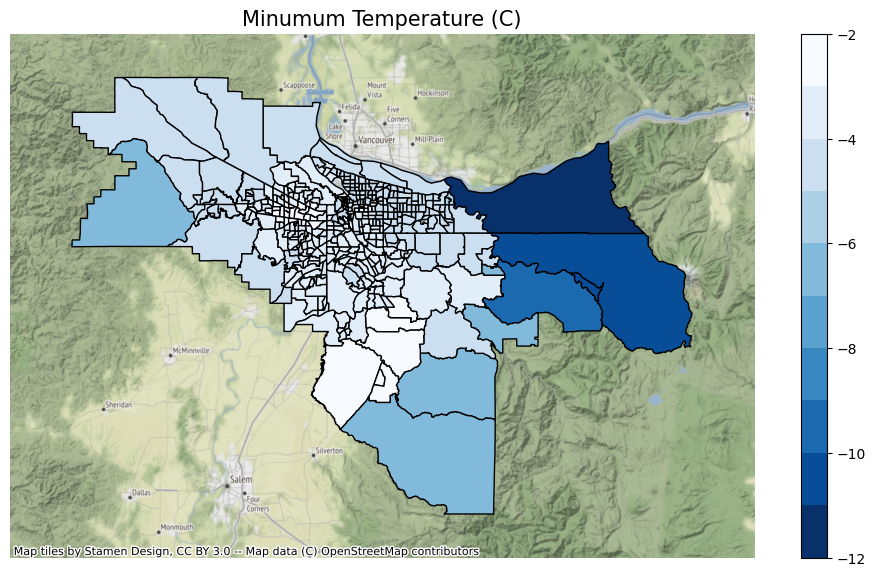

In [15]:
import contextily as cx
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
ax.set_title('Minumum Temperature (C)', size = 15)
shp_gpd.plot(ax=ax, column='tmin', edgecolor="black",
             cmap=plt.cm.get_cmap('Blues_r', 10),
             legend=True,legend_kwds={"shrink":.85}, vmin=-12, vmax=-2);  
#shp_gpd.plot(ax=ax, column='tmin', cmap = 'Blues', legend=True) #, scheme="quantiles");
plt.savefig(dir_o + 'PLOT/tmin_winterstorm_2021.png', bbox_inches='tight')

https://github.com/geopandas/geopandas/issues/961

- 1.2) Number of days with Tmin<0 for the event

In [16]:
from innovator_func import add_shape_coord_from_data_array
# Create a new coord for the ds indicating whether or not it is inside the shapefile
ds_da = add_shape_coord_from_data_array(ds.isel(time=0).isel(rlat=slice(88,122), rlon=slice(26, 82)), shp_gpd, "county")
county_2d = ds_da.county
#county_2d.plot()

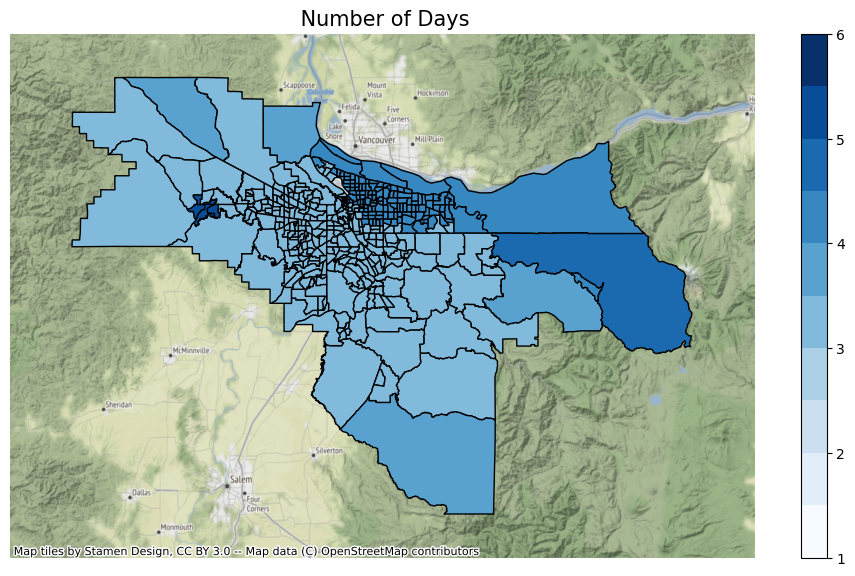

In [17]:
n_ice_3d = xr.where(ice_3d>0, 1, 0)
n_ice_2d = n_ice_3d.sum(dim='time') 

list_1d = []

for nn in range(n_shp):
    t_mean = n_ice_2d.where(county_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
    if np.isnan(t_mean):
        # when there is no grid point within the shape, use the nearest grid
        lat_0 = shp_gpd.lat_centroid[nn]
        lon_0 = shp_gpd.lon_centroid[nn]
        t = n_ice_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
        list_1d.append(t.values)
    else:
        list_1d.append(t_mean)

### NOTE:  use numpy array
shp_gpd['Nid'] = np.rint(np.asarray(list_1d))
shp_gpd['Nid'] = np.asarray(list_1d)

import contextily as cx
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
ax.set_title(' Number of Days', size = 15)
 
shp_gpd.plot(ax=ax, column='Nid', edgecolor="black",
             cmap=plt.cm.get_cmap('Blues', 10),
             vmin = 1, vmax = 6,legend=True,legend_kwds={"shrink":.85}) 
plt.savefig(dir_o + '/PLOT/NumIceDay_winterstorm_2021.png', bbox_inches='tight')

#### 2) Winter Storm in future senario
according to Sixth Oregon Climate Assessment of Erica Fleishman table 1 and 2
I want two tables side by side, instead of using
Image(url="t_future_change.png", width=300, height=300)

<table><tr>
<td> <img src="t_future_change.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="prec_future_change.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

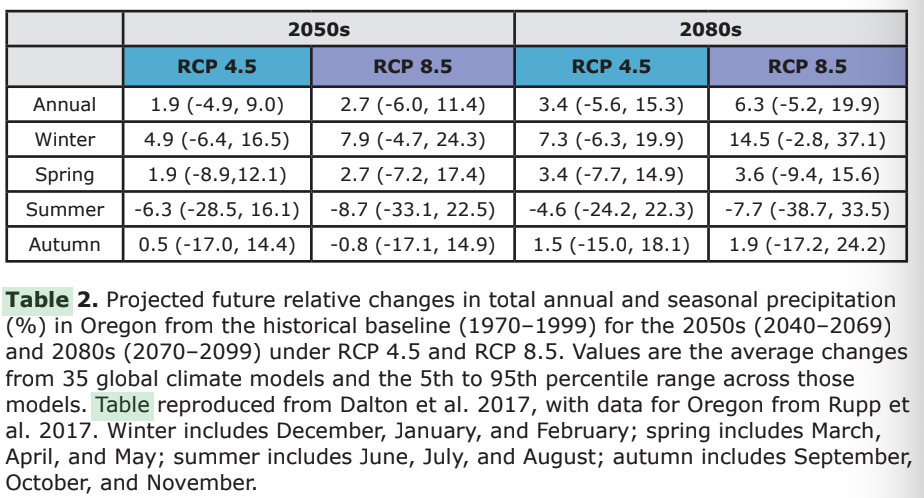
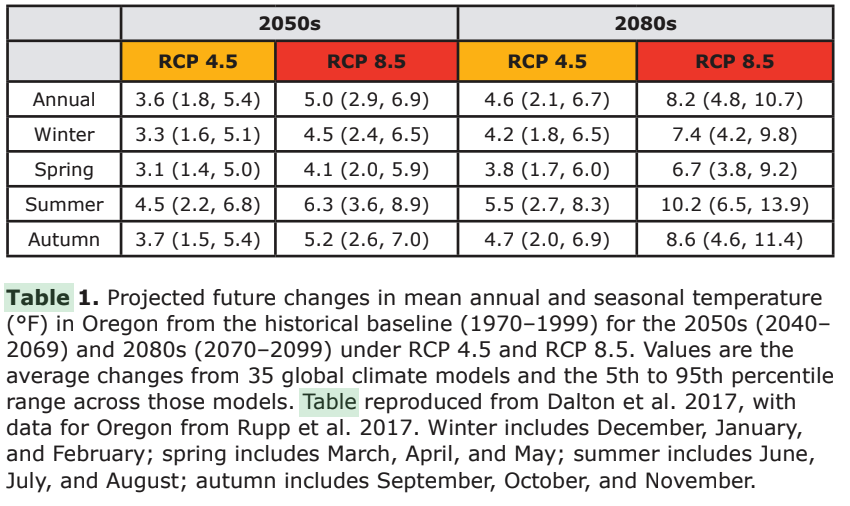

- 2.1) Projected changes  

In [20]:
# 2121 winter storm case adjustment
dt_2050s_RCP45_summer = (2055-2021)/(2055-1985)*4.5*5/9
dt_2050s_RCP85_summer = (2055-2021)/(2055-1985)*6.3*5/9

dt_2080s_RCP45_summer = (2085-2021)/(2085-1985)*5.5*5/9
dt_2080s_RCP85_summer = (2085-2021)/(2085-1985)*10.2*5/9

dprec_2050s_RCP45_summer = (2055-2021)/(2055-1985)*4.9*0.01
dprec_2050s_RCP85_summer = (2055-2021)/(2055-1985)*7.9*0.01

dprec_2080s_RCP45_summer = (2085-2021)/(2085-1985)*7.3*0.01
dprec_2080s_RCP85_summer = (2085-2021)/(2085-1985)*14.5*0.01

dt_1d = [dt_2050s_RCP45_summer, dt_2050s_RCP85_summer, dt_2080s_RCP45_summer, dt_2080s_RCP85_summer]
dp_1d = [dprec_2050s_RCP45_summer, dprec_2050s_RCP85_summer, dprec_2080s_RCP45_summer, dprec_2080s_RCP85_summer]

scen_1d =['2050s_RCP45', '2050s_RCP85', '2080s_RCP45', '2080s_RCP85'] 
n_scen = len(scen_1d)

In [21]:
ds = xr.open_dataset(dir_prism + 'Tmin/PRISM_daily_tmin_2021.nc')
tmin_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).Tmin

ds = xr.open_dataset(dir_prism + 'PR/PRISM_daily_ppt_2021.nc')
prec_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).PR


tmin_2050s_RCP45
Nid_2050s_RCP45
tmin_2050s_RCP85
Nid_2050s_RCP85
tmin_2080s_RCP45
Nid_2080s_RCP45
tmin_2080s_RCP85
Nid_2080s_RCP85


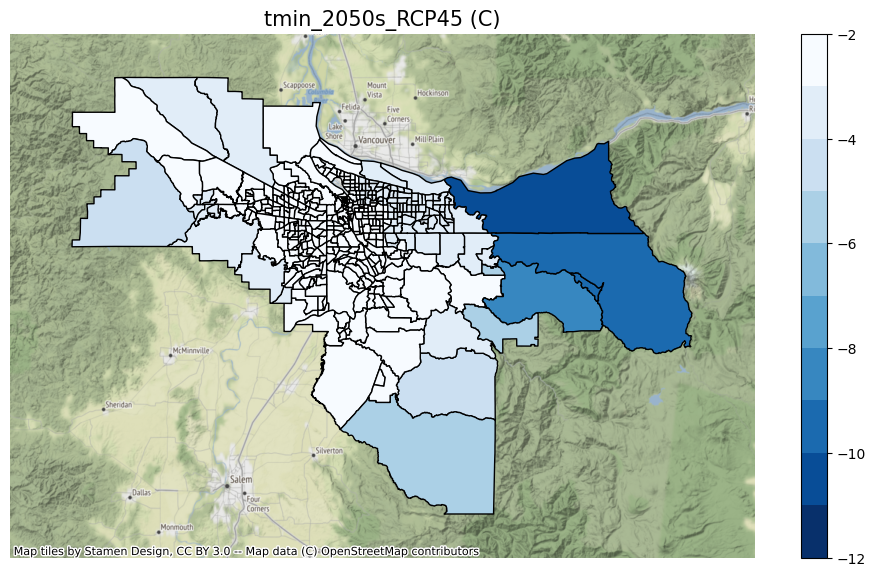

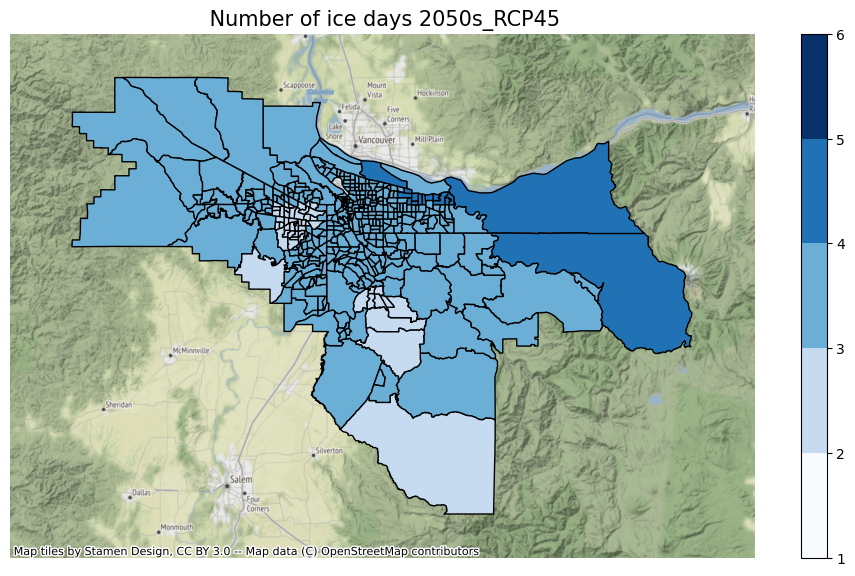

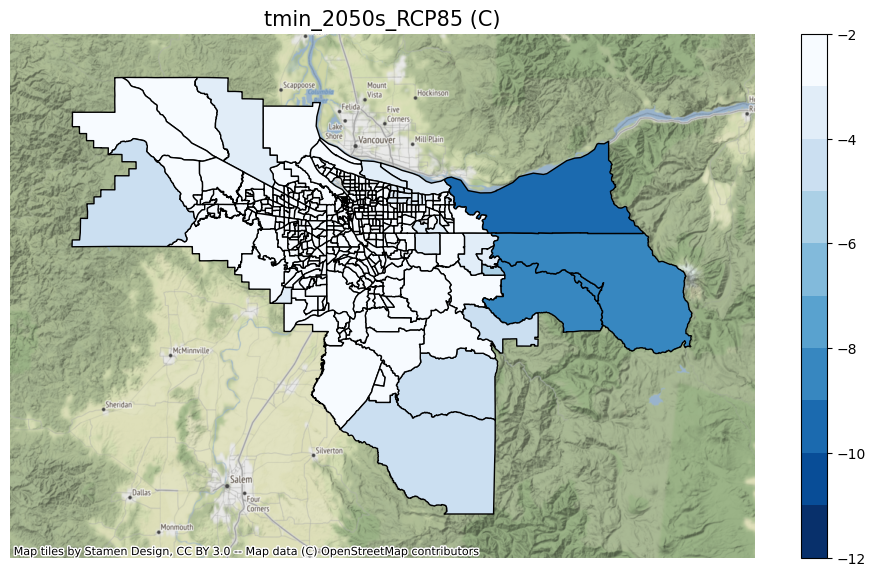

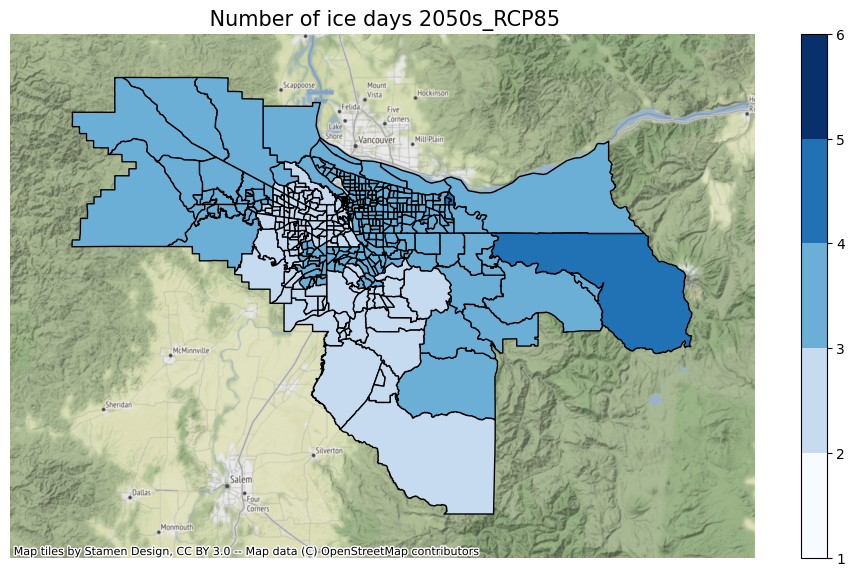

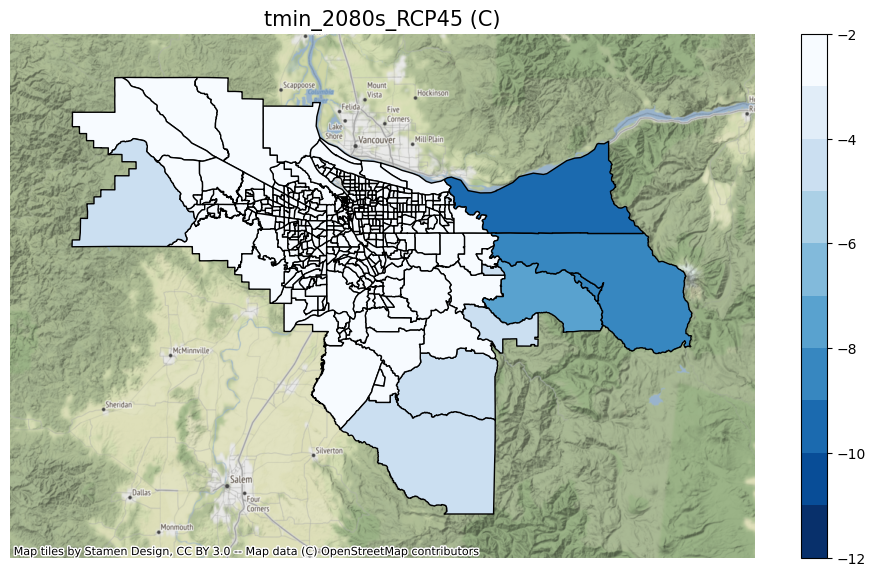

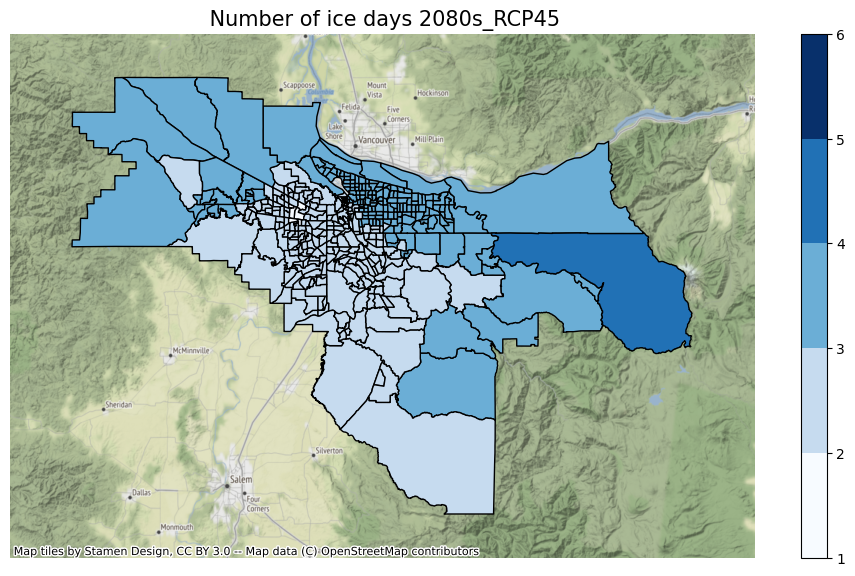

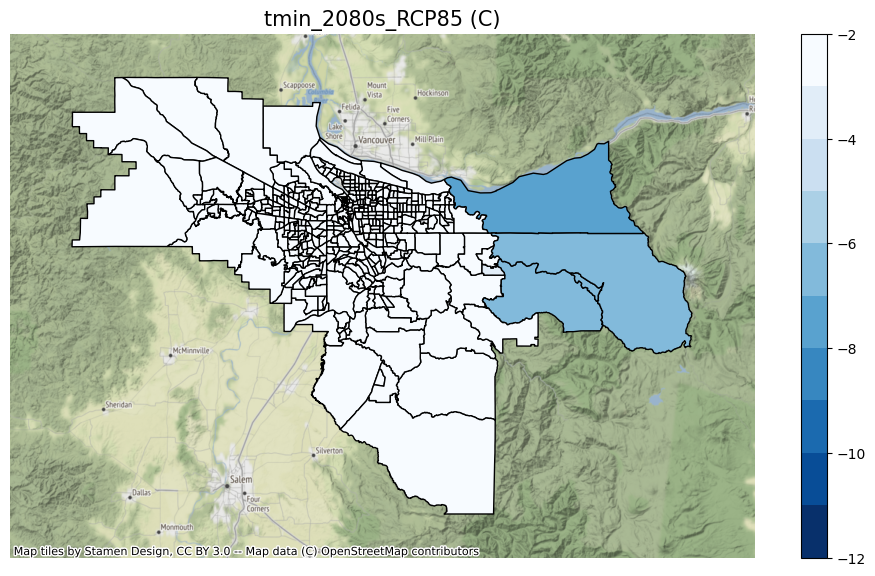

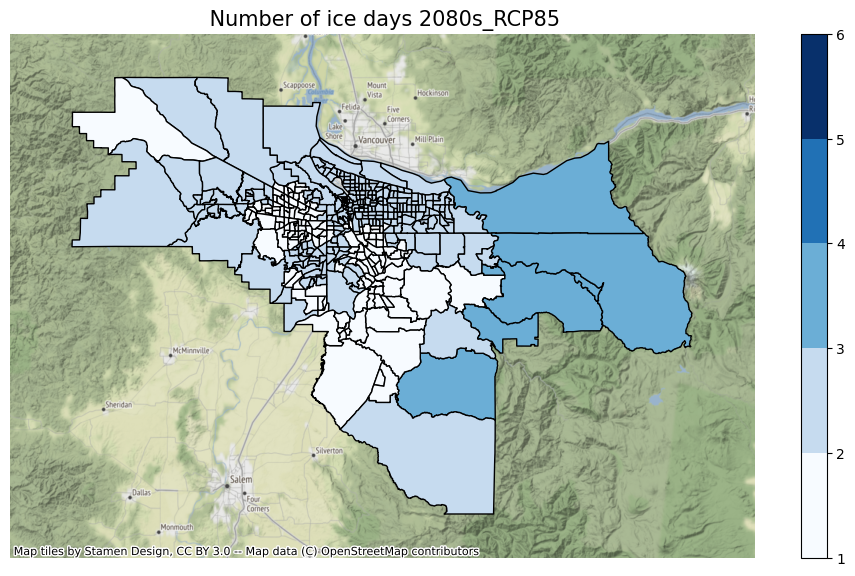

In [23]:
for ns in range(n_scen): 
    var_new  = 'tmin_' + scen_1d[ns]
    print(var_new)
    tmin_new = tmin_3d + dt_1d[ns]
    prec_new = prec_3d*(1+dp_1d[ns])
    ice_new  = prec_new.where(tmin_new<0, drop=False)
    
    n_ice_3d = xr.where(ice_new>0, 1, 0)
    n_ice_2d = n_ice_3d.sum(dim='time') 
    
    tmin_2d_new = tmin_new.min(dim='time') 
    
    list_1d = []
    for nn in range(n_shp):
        lat_0 = shp_gpd['lat_centroid'][nn]
        lon_0 = shp_gpd['lon_centroid'][nn]
        t = tmin_2d_new.sel(rlon=lon_0, rlat=lat_0, method="nearest")
        tmin_1d[nn]=t.values
        
        ni_mean = n_ice_2d.where(county_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
        if np.isnan(t_mean):
            # when there is no grid point within the shape, use the nearest grid
            lat_0 = shp_gpd.lat_centroid[nn]
            lon_0 = shp_gpd.lon_centroid[nn]
            ni = n_ice_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
            list_1d.append(ni.values)
        else:
            list_1d.append(ni_mean)
        
    shp_gpd[var_new] = tmin_1d 
    
    ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
    cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
    ax.set_title(var_new + ' (C)', size = 15)
    shp_gpd.plot(ax=ax, column=var_new, edgecolor="black",
             cmap=plt.cm.get_cmap('Blues_r', 10),
             legend=True,legend_kwds={"shrink":.85}, vmin=-12, vmax=-2);
    
    var_new  = 'Nid_' + scen_1d[ns]
    print(var_new)
    ### NOTE:  use numpy array
    shp_gpd[var_new] = np.rint(np.asarray(list_1d))
    shp_gpd[var_new] = np.asarray(list_1d)

    ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
    cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
    ax.set_title(' Number of ice days ' + scen_1d[ns], size = 15)
 
    shp_gpd.plot(ax=ax, column=var_new, edgecolor="black",
             cmap=plt.cm.get_cmap('Blues', 5),
             vmin = 1, vmax = 6,legend=True,legend_kwds={"shrink":.85})

In [28]:
shp_gpd.iloc[:, -10:]

tmin  Nid  tmin_2050s_RCP45  Nid_2050s_RCP45  tmin_2050s_RCP85  \
0   -3.9764  3.0         -2.762114                3           -2.2764   
1   -3.0689  3.0         -1.854614                3           -1.3689   
2   -3.3131  3.0         -2.098814                2           -1.6131   
3   -3.6716  3.0         -2.457314                3           -1.9716   
4   -3.2176  3.0         -2.003314                3           -1.5176   
..      ...  ...               ...              ...               ...   
411 -4.6109  4.0         -3.396614                3           -2.9109   
412 -4.0942  4.0         -2.879914                3           -2.3942   
413 -3.6629  3.0         -2.448614                3           -1.9629   
414 -3.6851  3.0         -2.470814                3           -1.9851   
415 -3.6629  3.0         -2.448614                3           -1.9629   

     Nid_2050s_RCP85  tmin_2080s_RCP45  Nid_2080s_RCP45  tmin_2080s_RCP85  \
0                  2         -2.020844                2         -0.349733   
1                  2         -1.113344                2          0.557767   
2                  2         -1.357544                2          0.313567   
3                  2         -1.716044                2         -0.044933   
4                  2         -1.262044                2          0.409067   
..               ...               ...              ...               ...   
411                3         -2.655344                3         -0.984233   
412                3         -2.138645                3         -0.467533   
413                3         -1.707344                2         -0.036233   
414                3         -1.729544                2         -0.058433   
415                3         -1.707344                2         -0.036233   

     Nid_2080s_RCP85  
0                  2  
1                  0  
2                  0  
3                  1  
4                  0  
..               ...  
411                2  
412                2  
413                2  
414                2  
415                2  

[416 rows x 10 columns]

#### save to shapefile

In [9]:
shp_gpd.to_file(dir_o + "DATA/winterstorm_2021.shp")

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/glade/scratch/mingge/ipykernel_175393/1807765183.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gpd.to_file(dir_o + "DATA/winterstorm_2021.shp")
